# Outcome Analysis for Parcel-Level CF Annotations

In [1]:
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyproj
import seaborn as sns
from tqdm import tqdm
from shapely import wkt
import shapely

tqdm.pandas()

In [3]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
CF_FP = os.path.join(OAK_FP, 'CloudFactory')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')

In [4]:
# Input data
# * Universe of SJ res parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

# * San Jose AANC permit data
permits = pd.read_csv(os.path.join(OAK_FP, 'outputs/Permit-Matching/outputs/all_permits.csv'))
permits['geometry_permit'] = gpd.GeoSeries.from_wkt(permits['geometry_permit'])
permits_2015_20 = permits.loc[
    permits['issue_year'].isin([2015, 2016, 2017, 2018, 2019, 2020])].copy()

In [5]:
def identify_construction_events(CF_FP, OAK_FP, params):
    
    # Load extracted polygons
    sbuild = pd.read_csv(
        os.path.join(OAK_FP, 'CloudFactory/results/Batch3/processed_buildings.csv'), 
        dtype={'apn': str})
    sbuild.rename(columns={'apn': 'APN'}, inplace=True)
    sbuild.reset_index(inplace=True, drop=False)
    sbuild.rename(columns={'index': 'building_index'}, inplace=True)
    assert len(sbuild['building_index'].unique()) == len(sbuild)
    
    # Make gdf for 2020
    sbuild20 = sbuild.copy()
    sbuild20.drop('2016', axis=1, inplace=True)
    sbuild20 = sbuild20.loc[~sbuild20['2020'].isna()]
    sbuild20['2020'] = sbuild20['2020'].apply(wkt.loads)
    sbuild20 = gpd.GeoDataFrame(sbuild20, geometry='2020', crs='EPSG:4326')
    
    # Define construction event
    sbuild_2020_compared = sbuild20.copy()
    sbuild_2020_compared['expansion_2016_flag'] = sbuild_2020_compared[params['event_type']]
    sbuild_2020_compared['expansion_2016_flag'] = sbuild_2020_compared['expansion_2016_flag'].astype(bool)

    return sbuild_2020_compared

In [6]:
def permit_match(OUTPUT_FP, permits_2015_20, sbuild_2020_compared, params):
    """
    Counts the number of newly constructed small buildings and the number of AANC permits issued
    during 2015-20 to determine what proportion are permitted vs unpermitted. 
    """
    
    # Get number of 2015-20 AANC permits per parcel
    parcel_permit_counts = permits_2015_20.copy()
    parcel_permit_counts = parcel_permit_counts.groupby('APN_parcel')['OBJECTID_left'].count().reset_index()
    parcel_permit_counts.rename(
        columns={'APN_parcel': 'APN', 'OBJECTID_left': 'pcount_2015_20'}, inplace=True)
    
    # Get new small building counts for each parcel
    new_sbuild_2020 = sbuild_2020_compared.loc[sbuild_2020_compared['expansion_2016_flag'] == True].copy()
    new_sbuild_2020 = new_sbuild_2020.groupby('APN')['expansion_2016_flag'].count().reset_index()
    new_sbuild_2020.rename(columns={'expansion_2016_flag': 'count_new_sbuild'}, inplace=True)
    
    # Merge permit and small building data
    new_sbuild_2020 = pd.merge(
        new_sbuild_2020, parcel_permit_counts[['APN', 'pcount_2015_20']], on='APN', 
        how='left', validate='one_to_one')

    # Fill parcel columns with zeros
    new_sbuild_2020[['pcount_2015_20']] = new_sbuild_2020[['pcount_2015_20']].fillna(value=0)

    # Compute unpermitted and permitted new small buildings at the parcel level
    new_sbuild_2020['count_new_sbuild_permitted'] = new_sbuild_2020.apply(
        lambda row: min(row['count_new_sbuild'], row['pcount_2015_20']), axis=1)
    new_sbuild_2020['count_new_sbuild_unpermitted'] = new_sbuild_2020[
        'count_new_sbuild'] - new_sbuild_2020['count_new_sbuild_permitted']

    assert new_sbuild_2020['count_new_sbuild_unpermitted'].sum() + new_sbuild_2020[
        'count_new_sbuild_permitted'].sum() == new_sbuild_2020['count_new_sbuild'].sum()
        
    # Print stats
    if params['verbose']:
        print('[INFO] Permitted small building constructions: {}'.format(
            new_sbuild_2020['count_new_sbuild_permitted'].sum() ))
        print('[INFO] Unpermitted small building constructions: {}'.format(
            new_sbuild_2020['count_new_sbuild_unpermitted'].sum() ))
        print('[INFO] Total small building constructions: {}'.format(
            new_sbuild_2020['count_new_sbuild'].sum() ))

    return new_sbuild_2020

In [7]:
def define_income_groups(cbg_df):
    # Generate quartile and neighborhood columns for each CBG
    if 'neighborho' in cbg_df.columns:
        cbg_df.drop('neighborho', axis=1, inplace=True)

    quartile_names = {'IS_0': 'Low', 'IS_1': 'Low-Moderate', 
                      'IS_2': 'High-moderate', 'IS_3': 'High', 'IS_4': 'Highest'}

    cbg_df['quintile'] = pd.qcut(
        cbg_df['median_inc'], q=5, 
        labels=['IS_{}'.format(i) for i in range(5)])

    cbg_df['quintile'] = cbg_df['quintile'].apply(
        lambda quartile: quartile_names[quartile])
    return cbg_df

In [8]:
def outcome_analysis(sj_parcels_cbgs, cbg_income_2016_SJ, new_sbuild_2020):

    cbg_income_2016_SJ_inc = define_income_groups(cbg_income_2016_SJ)

    sj_parcels_cbgs = pd.merge(
        sj_parcels_cbgs, cbg_income_2016_SJ_inc[['GEOID', 'quintile', 'median_inc']], 
        how='left',  validate='many_to_one')
    
    # Add GEOID, neighborhood and quintile
    outcome = new_sbuild_2020.copy()
    outcome = pd.merge(
        outcome, sj_parcels_cbgs[['APN', 'GEOID', 'quintile']], 
        how='left', validate='one_to_one')

    # Aggregate by quintile
    outcome_quintile = outcome.groupby('quintile')[
        ['count_new_sbuild_permitted', 'count_new_sbuild_unpermitted']].sum().reset_index()

    outcome_quintile['total_change'] = outcome_quintile['count_new_sbuild_permitted'] + outcome_quintile[
        'count_new_sbuild_unpermitted']
    outcome_quintile['permitted_proportion'] = outcome_quintile.apply(
        lambda row: row['count_new_sbuild_permitted'] / row['total_change'], axis=1)
    

    if params['verbose']:
        print(outcome_quintile)

        sns.barplot(data=outcome_quintile, x='quintile', y='permitted_proportion')
        plt.show()

        print('[INFO] Small building construction events across income quartiles')
        sns.barplot(data=outcome_quintile, x='quintile', y='total_change')
        plt.show()
        

In [9]:
def main(CF_FP, OAK_FP, OUTPUT_FP, permits_2015_20, sj_parcels_cbgs, cbg_income_2016_SJ, params):
    sbuild_2020_compared = identify_construction_events(CF_FP, OAK_FP, params)
    new_sbuild_2020 = permit_match(OUTPUT_FP, permits_2015_20, sbuild_2020_compared, params)
    outcome_analysis(sj_parcels_cbgs, cbg_income_2016_SJ, new_sbuild_2020)

# 1. Single run

In [10]:
params = {'event_type': 'change_area1.2', 'subset': 100, 'verbose': True}

[INFO] Permitted small building constructions: 27.0
[INFO] Unpermitted small building constructions: 340.0
[INFO] Total small building constructions: 367
        quintile  count_new_sbuild_permitted  count_new_sbuild_unpermitted  \
0            Low                         6.0                          60.0   
1   Low-Moderate                         5.0                          73.0   
2  High-moderate                         3.0                          82.0   
3           High                         9.0                          89.0   
4        Highest                         4.0                          36.0   

   total_change  permitted_proportion  
0          66.0              0.090909  
1          78.0              0.064103  
2          85.0              0.035294  
3          98.0              0.091837  
4          40.0              0.100000  


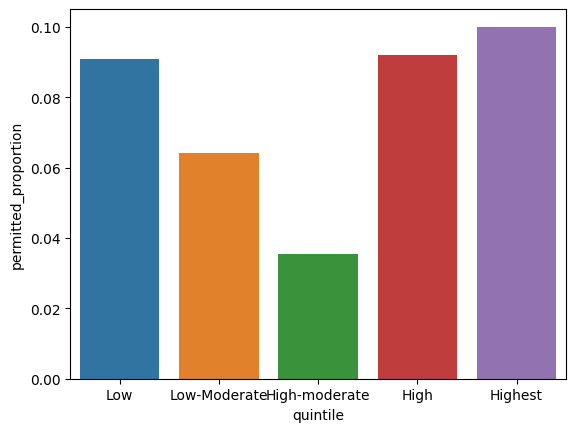

[INFO] Small building construction events across income quartiles


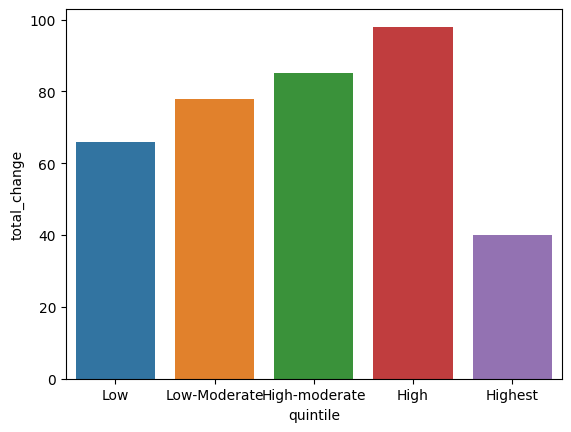

In [11]:
main(CF_FP, OAK_FP, OUTPUT_FP, permits_2015_20, sj_parcels_cbgs, cbg_income_2016_SJ, params)